In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings 
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [6]:
# Load only a subset of categories to simplify the classification task
categories = [
    'rec.sport.baseball', 'sci.med'
    , 'comp.graphics', 'talk.politics.misc']

newsgroups = fetch_20newsgroups(
    subset='all'
    , categories=categories
    , remove=('headers', 'footers', 'quotes')  # remove metadata
)

# Create a DataFrame for convenience
df = pd.DataFrame({
    'text': newsgroups.data
    , 'label': newsgroups.target
})

In [7]:
# Drop rows where text is empty or null
df.dropna(subset=['text'], inplace=True)
df = df[df['text'].str.strip() != '']

# Confirm cleaned data
df.shape

(3629, 2)

In [9]:
# Set up our features (X) and labels (y):

X = df['text']
y = df['label']

X.shape, y.shape

((3629,), (3629,))

In [10]:
# Split into up our train/test datasets:

X_train, X_test, y_train, y_test = train_test_split(
    X, y
    , test_size=0.2
    , random_state=27
    , stratify=df['label']
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2903,), (726,), (2903,), (726,))

In [11]:
# Vectorize text data using TfidfVectorizer:

tfidf = TfidfVectorizer(
    stop_words='english'
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [23]:
# Check the size of the sparse matrix; (its huge! {vector-size-wise}):

X_train_tfidf

X_train_tfidf.shape

<2903x32258 sparse matrix of type '<class 'numpy.float64'>'
	with 199242 stored elements in Compressed Sparse Row format>

(2903, 32258)

In [13]:
# Set up quick,baseline models with a few different classifier algos to see which works best; 

models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(
        max_iter=1000, solver='liblinear'
    ),
    'SVC': SVC(),
    'LinearSVC': LinearSVC()
}

# Evaluate models
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

MultinomialNB()

MultinomialNB Accuracy: 0.9091


LogisticRegression(max_iter=1000, solver='liblinear')

LogisticRegression Accuracy: 0.9077


SVC()

SVC Accuracy: 0.9132


LinearSVC()

LinearSVC Accuracy: 0.9146


In [14]:
# Since the LinearSVC produced the best accuracy score, lets implement that for our final model'

# Use pipeline to run the baseline steps (vectorize, model integration)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english', lowercase=True))
    , ('clf', LinearSVC(dual=False))
])

# Set up the hyperparams; (will be specific to the chosen model...)
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0]
    , 'tfidf__ngram_range': [(1, 1), (1, 2)]
    , 'clf__C': np.logspace(-3, 1, 5)
}

# Build the grid, w/ pipes we built;
grid = GridSearchCV(
    pipeline
    , param_grid
    , cv=5
    , scoring='accuracy'
    , n_jobs=-1
)

In [15]:
# Fit the grid; REMEMBER: since we vectorized tfidf in the Pipeline, we fit to the RAW TRAINING DATA! (attempting to fit to X_train_tfidf will throw errors!)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf', LinearSVC(dual=False))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [33]:
# print("Best Parameters:\n", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

grid.best_params_
grid.best_score_

{'clf__C': 10.0, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}

0.9321389993471423

In [31]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LinearSVC(C=10.0, dual=False))])

In [32]:
# Final evaluation on test set
final_preds = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, final_preds))
confusion_matrix(y_test, final_preds)
print(classification_report(y_test, final_preds))

Test Accuracy: 0.918732782369146


array([[184,   4,   0,   3],
       [  3, 181,   2,   6],
       [  9,   3, 171,   9],
       [  3,   8,   9, 131]])

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       191
           1       0.92      0.94      0.93       192
           2       0.94      0.89      0.91       192
           3       0.88      0.87      0.87       151

    accuracy                           0.92       726
   macro avg       0.92      0.92      0.92       726
weighted avg       0.92      0.92      0.92       726



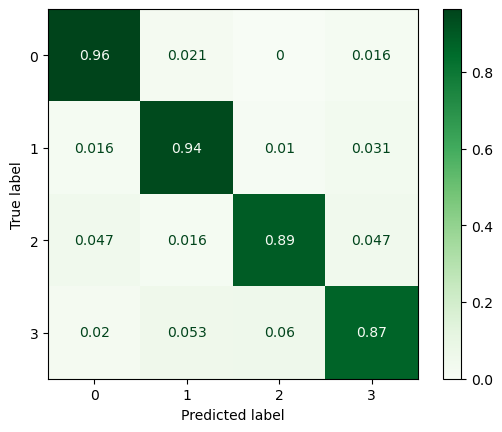

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test
    , normalize='true', cmap='Greens'
);

In [22]:
best_model = grid.best_estimator_

sample_texts = [
    "The new graphics card has amazing rendering performance.",
    "The government passed a new healthcare reform bill.",
    "Baseball season is in full swing with exciting games."
]

predictions = best_model.predict(sample_texts)

for text, pred in zip(sample_texts, predictions):
    print(f'"{text[:60]}..." -> Predicted Category: {newsgroups.target_names[pred]}\n')

"The new graphics card has amazing rendering performance...." -> Predicted Category: comp.graphics

"The government passed a new healthcare reform bill...." -> Predicted Category: talk.politics.misc

"Baseball season is in full swing with exciting games...." -> Predicted Category: rec.sport.baseball

